# Triplet loss

Example showcasing how to use skorch with triplet loss.

At first glance, it might not be quite obvious how to implement something like nets that use contrastive loss or triplet loss with skorch. Here is an example of using triplet loss that could be used as a starting point.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNet
from skorch.utils import data_from_dataset
from skorch.toy import MLPModule
import torch
from torch import nn
from torch.utils.data import Sampler, BatchSampler

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
plt.style.use('seaborn')

In [4]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prepare data

Use an artificial dataset consisting of 3 classes.

In [5]:
X, y = make_classification(2000, n_features=50, n_informative=40, n_classes=3)

In [6]:
X, y = make_classification(2000, n_features=50, n_informative=40, n_classes=5)

In [7]:
X = X.astype(np.float32)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

## Custom code

### Fast random choice

In [9]:
def fast_rand_choice(elems, p):
    """Choose a random element weighted by p.

    Faster than np.random.choice, assumes that sum of p is one.

    Thanks to: https://twitter.com/radimrehurek/status/928671225861296128

    """
    return elems[np.searchsorted(np.cumsum(p), np.random.random())]

### Custom skorch code

In [10]:
class TripletSampler(torch.utils.data.Sampler):
    """Sampler that returns triplets during training.

    At inference time (no y), only returns the normal samples.
    
    Use this in confunction with a skorch.dataset.Dataset.
    The batch size must be a multiple of 3.

    """
    def __init__(self, data_source, shuffle=False):
        self.data_source = data_source
        self.shuffle = shuffle

        self._indices = np.arange(len(self.data_source))
        if self.shuffle:
            np.random.shuffle(self._indices)

    @staticmethod
    def get_sample_weight_pos(y, i):
        sample_weight = y == y[i]
        sample_weight[i] = 0
        sample_weight = sample_weight / sample_weight.sum()
        return sample_weight

    @staticmethod
    def get_sample_weight_neg(y, i):
        sample_weight = y != y[i]
        sample_weight = sample_weight / sample_weight.sum()
        return sample_weight

    def __iter__(self):
        _, y = data_from_dataset(self.data_source)
        is_inference = y is None

        for i in self._indices:
            yield i
            if is_inference:
                continue

            p_pos = self.get_sample_weight_pos(y, i)
            j = fast_rand_choice(self._indices, p=p_pos)
            yield j

            p_neg = self.get_sample_weight_neg(y, i)
            k = fast_rand_choice(self._indices, p=p_neg)
            yield k

    def __len__(self):
        return len(self.data_source)

In [11]:
def triplet_dataloader(ds, **kwargs):
    """Returns a DataLoader that uses TripletSampler.
    
    Batch size should be a multiple of 3.
    
    """
    shuffle = False
    if 'shuffle' in kwargs:
        shuffle = kwargs.pop('shuffle')

    sampler = TripletSampler(ds, shuffle=shuffle)
    dl = torch.utils.data.DataLoader(ds, sampler=sampler, **kwargs)
    yield from dl

In [12]:
class TripletNet(NeuralNet):
    """Modified NeuralNet that works with TripletMarginLoss
    
    Batch size should be a multiple of 3.
    
    """
    def get_loss(self, y_pred, y_true, X=None, training=False):
        if len(y_pred) % 3 != 0:
            raise ValueError("Batch size must be a multiple of 3, get {} instead.".format(len(y_pred)))

        y_anchor = y_pred[::3]
        y_pos = y_pred[1::3]
        y_neg = y_pred[2::3]
        return self.criterion_(y_anchor, y_pos, y_neg)

## Training

Use a simple MLP and `TripletMarginLoss` to embed the 50-dimensional input space into a 2-dimensional output space. The loss takes care of separating the 3 classes.

In [13]:
net = TripletNet(
    MLPModule,
    module__input_units=X.shape[1], 
    module__output_units=2,
    module__num_hidden=2,
    module__hidden_units=200,

    optimizer=torch.optim.Adam,
    lr=1e-3,
    criterion=nn.TripletMarginLoss,
    criterion__margin=1,
    max_epochs=20,
    
    iterator_train=triplet_dataloader,
    #iterator_train__shuffle=True,
    iterator_valid=triplet_dataloader,
    batch_size=3*32,  # must be a multiple of 3

    device=device,
)

In [14]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.9749        0.9908  0.5012
      2        0.9871        0.9641  0.4582
      3        0.9138        0.8881  0.4816
      4        0.7909        0.8876  0.6652
      5        0.7392        0.7849  0.5281
      6        0.6578        0.7464  0.5551
      7        0.5916        0.8120  0.6516
      8        0.5110        0.7412  0.4454
      9        0.4437        0.8141  0.4300
     10        0.3780        0.7580  0.4355
     11        0.3398        0.6124  0.4962
     12        0.2880        0.6871  0.4598
     13        0.2397        0.6823  0.4312
     14        0.1907        0.6851  0.4371
     15        0.1712        0.6438  0.4359
     16        0.1679        0.6740  0.4656
     17        0.1516        0.6284  0.4359
     18        0.1113        0.6155  0.4566
     19        0.1260        0.6080  0.4469
     20        0.1082        0.5998  0.4513


<class '__main__.TripletNet'>[initialized](
  module_=MLPModule(
    (nonlin): ReLU()
    (sequential): Sequential(
      (0): Linear(in_features=50, out_features=200, bias=True)
      (1): ReLU()
      (2): Dropout(p=0)
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): ReLU()
      (5): Dropout(p=0)
      (6): Linear(in_features=200, out_features=2, bias=True)
    )
  ),
)

## Visualization

Use the hold-out validation data to show that the net learned to separate the 3 classes.

In [15]:
X_emb = net.predict(X_valid)

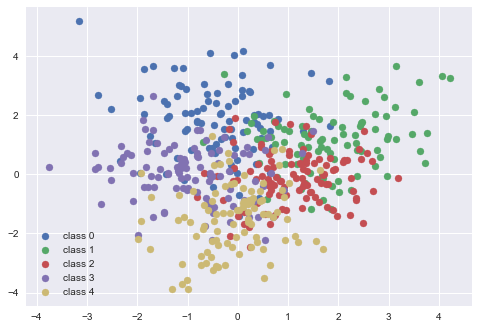

In [16]:
for yi in set(y_valid):
    mask = y_valid == yi
    plt.scatter(X_emb[mask, 0], X_emb[mask, 1], label="class {}".format(yi))
plt.legend()

## Predicting on the embeddings

We train a simple KNN classifier, once on the original input features, `X_valid`, and once on the embedded features, `X_emb`. The classifier is actually more accurate on the embedded features, meaning that the embeddings are indeed useful.

In [17]:
scores = cross_val_score(KNeighborsClassifier(), X_valid, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.5338887555022008

In [18]:
scores = cross_val_score(KNeighborsClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.6257022809123649

Just for completeness, we show that a dummy classifier performs much worse on the same data, proving that the results are not due to luck.

In [19]:
scores = cross_val_score(DummyClassifier(), X_emb, y_valid, scoring='accuracy', cv=5)
scores.mean()

0.2038327330932373